In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.stats import pearsonr
from scipy.special import expit
import copy

np.random.seed(333)

# Gibbs sampling with refractory period

In [3]:
images = np.load('images_zca_norm.npy')
PFs = np.load('pfs.npy')

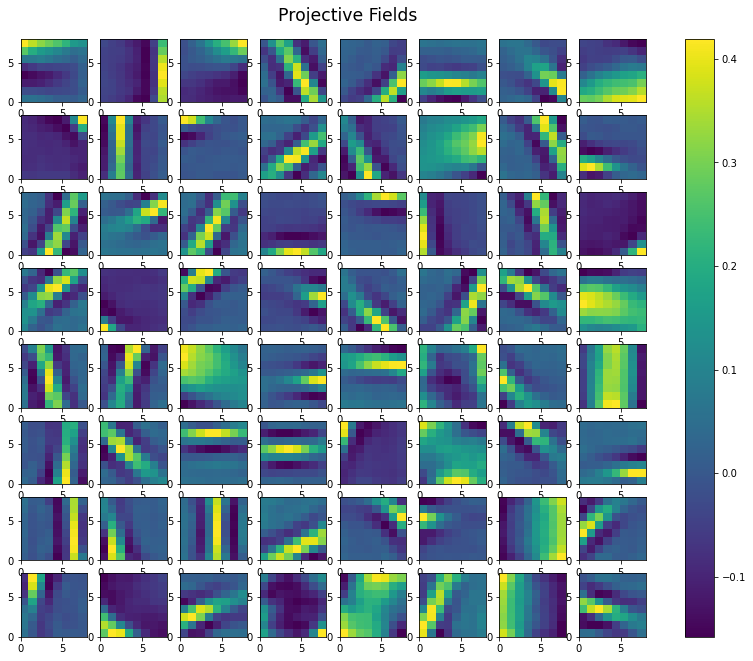

In [5]:
fig, axes = plt.subplots(nrows=8, ncols=8, figsize=(14, 11))

for i in range(8):
    for j in range(8):
        order = i*8 +j                             # neuron number
        ax = axes[i][j].pcolormesh(PFs[order])
        
fig.colorbar(ax, ax=axes[:, :], location='right')

fig.suptitle('Projective Fields', x = 0.45, y = 0.92, size = 'xx-large')

#fig.tight_layout(pad=3.0)
plt.show()

## Initiation of the parameters and setup

**Our model is implementing a post synaptic potential dependent network characterization. This model assumes a hard refractory period, and uses 1 ms time step to approximate the continuous time behavior.**

**After our trials with the sampling scheme, we noticed that we need to scale the post synaptic potential function to make a reasonable sampling. In the post synaptic potential there are three different competing terms. Bias term contributes to the post synaptic potential taking have well the projective field match the given image into account. On the other hand, time course part and the log of the hard refractory period time tau decreases the post synaptic potential. The former one punishes spiking at the same time with another neuron weighting it with the correlation between them, and the latter is aiming to prevent too frequent spiking with using the resolution of our sampling scale. For example, we are using 1 ms steps and due to that reason we are punished to start from -log(5) post synaptic potential for tau = 5 ms.**

**To handle this situation we choose hard refractory period tau as 5 ms, since choosing a higher value in 1 ms resolution will gets the post synaptic potential away from the selective zone of the sigmoid function which is around zero. On the other hand, since the sigmoid function is a very smooth non-linear filter, we scale up our post synaptic potential to increase its selectivity.**

In [268]:
z_initial = np.random.binomial(1, 0.1, 64)      # Draw initial z vector from a Gaussian dist.
                                                # Here we used small probability to shorten the burn-in time
                                                # z defines if a neuron is firing or not, being either 1 or 0
Pf = np.transpose(PFs.reshape(64,64))           # Define weight matrix such as
                                                # every column corresponds to PF of the corresponding neuron
W = np.matmul(np.transpose(Pf[:,:]),Pf[:,:])    # Generate weight matrix 
Time = 0.5 #sec
delta_T = 0.001 #sec
N_sampling = int(Time/delta_T)                  # Sampling count = 500
tau = 5 #msec                                     Hard refractory period

In [269]:
def post_synaptic_potential(Image, i, z):
    weight_i = copy.copy(W[i])
    weight_i[i] = 0                                                    # w_ii = 0
    time_course = np.matmul(np.transpose(weight_i),z)                  # how other neurons contribute PSP now
    bias = np.matmul(np.transpose(Pf[:,i]),Image.reshape(64,1))        # regulation of own excitability
    return bias - time_course

In [270]:
def Gibbs_sampling(Image, n_sampling):
    response_matrix = np.zeros([64,n_sampling])  # Initiate sampling matrix
    response_matrix[:,0] = z_initial             # Set z_initial as the first column
    
    ζ = np.zeros([64,n_sampling])                # accompanying matrix showing the refractory period
    ζ[:,0] = z_initial*tau                       # firing neurons get into refractory period
    
    spike_timing = np.zeros([64,n_sampling])     # record spike times
    
    for i in range(1, n_sampling):               # Start from the second column, and iterate through time
        response_matrix[:,i] = response_matrix[:,i-1]

        for j in range(64):                       
            if ζ[j, i-1] <= 1:                   # Make a draw if refractory period is end
                
                response_matrix[j, i] = 0
                transfer_ij = expit(4*(post_synaptic_potential(Image, j, response_matrix[:,i])\
                                    - np.log(tau))) # expit for sigmoid fct
                response_matrix[j,i] = np.random.binomial(1, transfer_ij)
                
                if response_matrix[j,i] == 1:   # update refractory period
                    ζ[j, i] = tau                
                    spike_timing[j, i] = i      # record spike time
                else:
                    ζ[j, i] = 0
                
            else:
                ζ[j, i] = ζ[j, i-1] - 1
   
    return response_matrix

In [271]:
expit(post_synaptic_potential(Pf[:,28], 43, z_initial) - np.log(tau))

array([0.1644089])

In [272]:
def posterior_prob_r(Image, n_sampling):
    response = Gibbs_sampling(Image, n_sampling)
    return [np.sum(response[i])/n_sampling for i in range(64)]  # Return firing percentage

In [273]:
post_synaptic_potential(Pf[:,sample_neuron_number], 5, z_initial)

array([-0.65987759])

## Trial with a sample projective field

**In this part we will try our setup by feeding one of the projective fields back into our sampling function. We expect to see a dominant firing pattern by the same neuron sensitive to that projective field.**

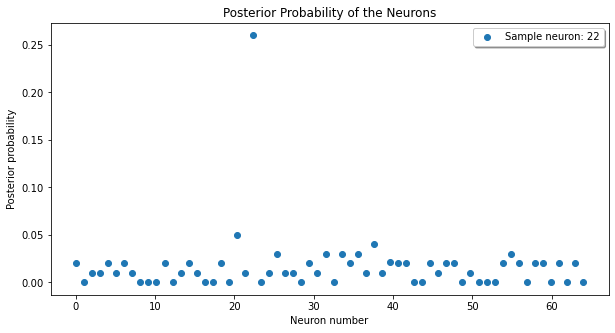

In [274]:
sample_neuron_number = 22
total_time = 1 #sec
sampling_rate = 1/5e-3
numberOFsampling = int(total_time*sampling_rate)
plt.figure(figsize = (10,5))
plt.scatter(np.linspace(0,64,64), posterior_prob_r(Pf[:,sample_neuron_number], N_sampling))
plt.title('Posterior Probability of the Neurons')
plt.xlabel('Neuron number')
plt.ylabel('Posterior probability')
plt.legend(["Sample neuron: %.0f" %sample_neuron_number], loc='upper right', fancybox=True, shadow=True)

Text(0, 0.5, 'Neuron number')

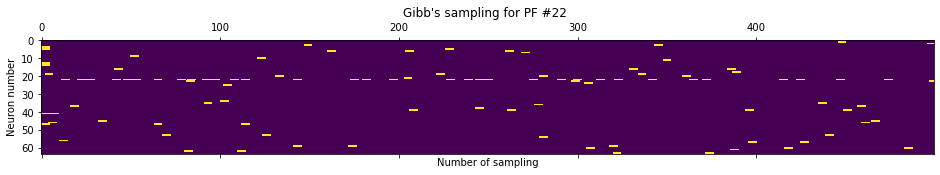

In [275]:
response = Gibbs_sampling(Pf[:,sample_neuron_number], N_sampling);

plt.matshow(response)
plt.title("Gibb's sampling for PF #%.f "%sample_neuron_number)
plt.xlabel("Number of sampling")
plt.ylabel('Neuron number')

**We see a dominant firing pattern by the neuron representing the same projective field as we expected. However, there is a suboptimal behavior araising from the characteristic of the sigmoid function. It is a rather smooth non-linearity and allows a lot of unnecessary firing patterns coming from irrelevant neurons, and that leads to a noisy inferred image.**

## Trial with combination of projective fields

**We choosed two different PF couples with low and high correlation. In this way we can see the performance of the PFs and observe the competation bw the PFs with high correlation.**

In [276]:
def I_est(I, numberOFsampling):
    I_64 = I.reshape(64)
    posterior_array = posterior_prob_r(I_64, numberOFsampling)
    weighted_PFs = np.matmul(Pf,posterior_array)
    return weighted_PFs.reshape(8,8)

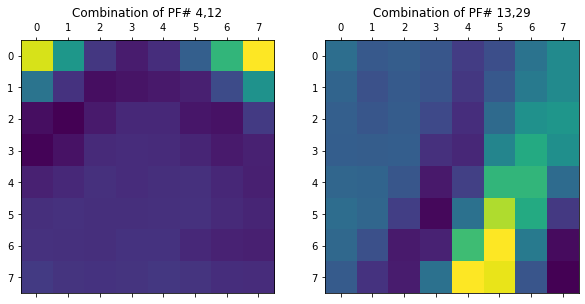

In [277]:
average_24_26 = (Pf[:,23].reshape(8,8)+Pf[:,25].reshape(8,8))/2
average_15_23 = (Pf[:,14].reshape(8,8)+Pf[:,22].reshape(8,8))/2

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

ax = axes[0].matshow(average_24_26)
ax = axes[1].matshow(average_15_23)

axes[0].set_title('Combination of PF# 4,12')
axes[1].set_title('Combination of PF# 13,29')

plt.show()

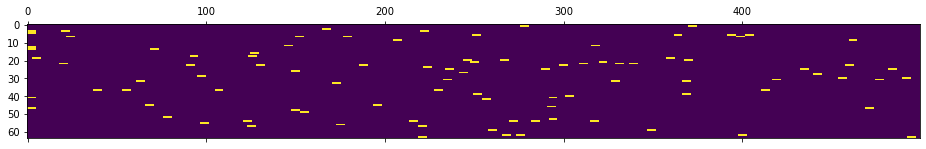

In [278]:
response_24_26 = Gibbs_sampling(average_24_26.reshape(64), N_sampling)
plt.matshow(response_24_26)

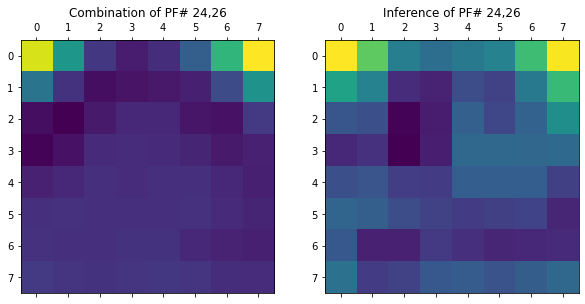

In [279]:
I_estimate_24_26 = I_est(average_24_26, N_sampling)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

ax = axes[0].matshow(average_24_26)
ax = axes[1].matshow(I_estimate_24_26)

axes[0].set_title('Combination of PF# 24,26')
axes[1].set_title('Inference of PF# 24,26')

plt.show()

In [280]:
corr_24_26 = pearsonr(I_estimate_24_26.reshape(64),average_24_26.reshape(64))
corr_24_26

(0.8583992538993842, 1.2423775681256401e-19)

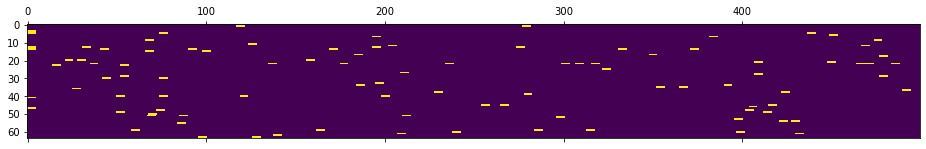

In [281]:
response_15_23 = Gibbs_sampling(average_15_23.reshape(64), N_sampling)
plt.matshow(response_15_23)

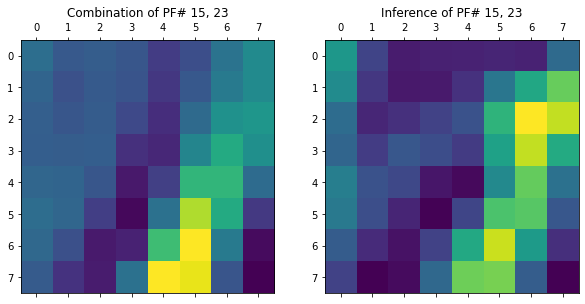

In [282]:
I_estimate_15_23 = I_est(average_15_23, numberOFsampling)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

ax = axes[0].matshow(average_15_23)
ax = axes[1].matshow(I_estimate_15_23)

axes[0].set_title('Combination of PF# 15, 23')
axes[1].set_title('Inference of PF# 15, 23')

plt.show()

In [283]:
corr_15_23 = pearsonr(I_estimate_15_23.reshape(64),average_15_23.reshape(64))
corr_15_23

(0.8158074241978399, 2.2062604199694778e-16)

Comparison of the correlation coefficient of the combined PFs is as follows

In [156]:
print("The correlation between the PF 4, and 12 is %.3f" %pearsonr(PFs[23].reshape(64),PFs[25].reshape(64))[0])
print("The correlation between the PF 15, and 23 is %.3f" %pearsonr(PFs[14].reshape(64),PFs[22].reshape(64))[0])  

The correlation between the PF 4, and 12 is -0.079
The correlation between the PF 15, and 23 is 0.131


**As we found out at the end of the previous part, sigmoid function is resulting in quite amount of noise. Even in the combination of the projective fields, there occurs quite amount of irrelevant spiking patterns due to our non-linear filter.**

## Mean correlation vs number of sampling

**We will try to explore the relation between sampling time and the performance of the sampling. We will compare the correlation between the original image and the inferred image. Correlation is measured by using pearsonr function scipy library.**

In [262]:
rand_order = np.random.choice(10000, 1000, replace=False)       # Draw order of the images randomly
rand_images = np.zeros([1000,8,8])                              # Create empty array
i = 0
while i < 1000:                                                 # Chose random images from the collection
    rand_images[i] = images[rand_order[i]]                      # with the order drawn above
    i += 1

In [265]:
def calc_correlation(images, n_sampling):
    
    collection_length = np.shape(images)[0]
    est_images = []                               # Initiate list for image estimates
    correlation = []                              # Initiate list for correlation coeff.s
    p_value = []                                  # Initiate list for p values for corr. coeff.s
    
    for i in range(collection_length):            # Find correlation. Iterate over all selected images
        estimate = I_est(images[i],n_sampling)
        c_coeff, p = pearsonr(images[i].reshape(64), estimate.reshape(64))
        est_images.append(estimate)
        correlation.append(c_coeff)
        p_value.append(p)
        
    return    est_images,   correlation,   p_value        

In [266]:
est, corr, p = calc_correlation(rand_images, numberOFsampling)

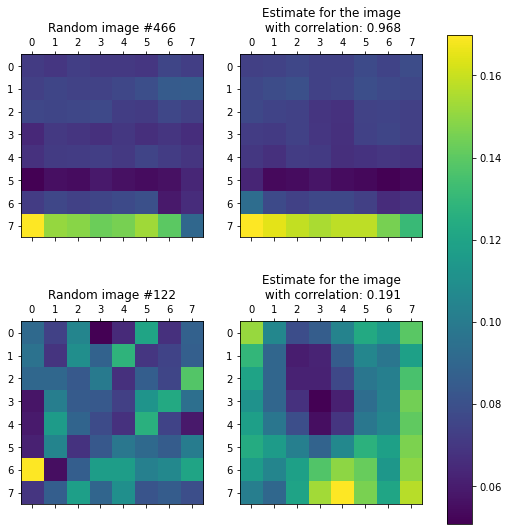

In [267]:
max_corr_order = corr.index(max(corr))
min_corr_order = corr.index(min(corr))

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 9))

ax = axes[0][0].matshow(rand_images[max_corr_order])
ax = axes[0][1].matshow(est[max_corr_order])
ax = axes[1][0].matshow(rand_images[min_corr_order])
ax = axes[1][1].matshow(est[min_corr_order])

axes[0][0].set_title('Random image #%.f' %max_corr_order)
axes[0][1].set_title('Estimate for the image\n with correlation: %.3f' %corr[max_corr_order])
axes[1][0].set_title('Random image #%.f' %min_corr_order)
axes[1][1].set_title('Estimate for the image\n with correlation: %.3f' %corr[min_corr_order])

fig.colorbar(ax, ax=axes[:, :], location='right')

plt.show()

**We still see the noisy character of the sigmoid function. The unnecessary firing pattern arising from it, results in a very unpredictable correlation scale. It can go from high correlation to no correlation at all! This was not the case for our findings in the last assignment with the same projective field set. The correlation range was varying between nearly 0.5 to 1.**

In [268]:
est_images = np.array([I_est(rand_images[i],numberOFsampling) for i in range(1000)])

**With the last part we make sure that there is no problem with our inference scheme. Then, we can move on and test the effect of number of sampling over the performance of the correlation.**

In [269]:
n_sampling = np.linspace(10, 300, 10, dtype = int)
mean_correlation = []

for i in n_sampling:
    estI, corrI, pI = calc_correlation(rand_images, i)
    mean_correlation.append(np.mean(corrI))

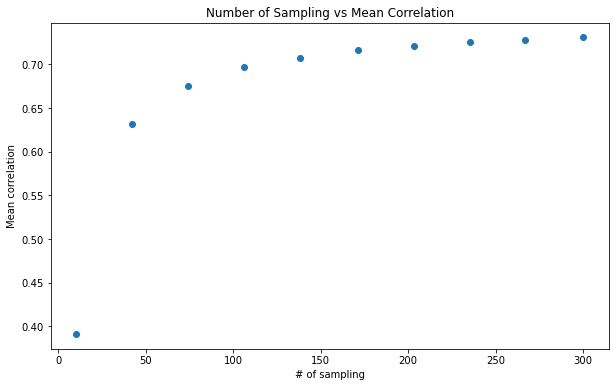

In [270]:
plt.figure(figsize=(10,6));
plt.scatter(n_sampling, mean_correlation);
plt.title("Number of Sampling vs Mean Correlation");
plt.xlabel("# of sampling");
plt.ylabel("Mean correlation");

**As we expected the value the performance approaches .1 below the former sampling scheme. However, the effect of the number of sampling on the performance is the same.**

## Rotating sine wave

**We will start by generating sine wave, and reproduce it with the changing orientation.**

Text(0.5, 1.0, 'Sin(x) wave with -pi/3 rotation')

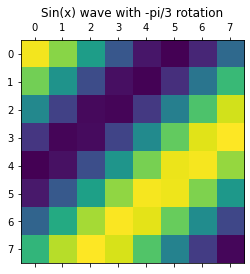

In [271]:
x = np.linspace(-np.pi, np.pi, 8)
y = np.linspace(-np.pi, np.pi, 8)

def sin_wave(x, y, rotation):
    xx, yy = np.meshgrid(x,y) 
    z = np.sin(xx*np.cos(rotation) - yy*np.sin(rotation))       
    return z

rot_angles = np.linspace(-np.pi, np.pi, 12)                                    # Define rotation angles
rotating_images = np.array([sin_wave(x, y, rot_angles[i]) for i in range(12)]) # One-liner for oriented image generation
plt.matshow(rotating_images[4])
plt.title("Sin(x) wave with -pi/3 rotation")

**Above, we see make sure that we succesfully generate the rotating sine wave. Now, we can test how each projective field responds according to rotation of the wave.**

In [276]:
posterior_rotating_sine = np.array([posterior_prob_r(rotating_images[i].reshape(64), numberOFsampling)\
                                    for i in range(12)])

print(np.shape(posterior_rotating_sine))

(12, 64)


Text(0.5, 0, 'Orientation of the sin wave')

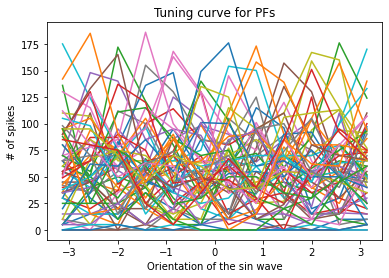

In [277]:
for i in range(64):
    plt.plot(rot_angles, posterior_rotating_sine[:,i]*numberOFsampling)
plt.title("Tuning curve for PFs")
plt.ylabel("# of spikes")
plt.xlabel("Orientation of the sin wave")

In [278]:
print("Mean firing rate for PFs are %.1f."%np.mean(posterior_rotating_sine*numberOFsampling))

Mean firing rate for PFs are 56.1.


**These tuning curves just approves the observation we made before. Since the sigmoid function is suboptimal when it comes to emphasizing the small changes, it creates a lot of noise, and makes it harder to detect the difference between the orientation of an image. We can observe that, a lot of neuron spikes continuously and generates quite amount of noise, whereas a few of the neurons barely spikes more frequently over them and tries to infer the image.**

## ISI distribution and CV of this ditribution

In [287]:
def Gibbs_sampling_timing(Image, n_sampling):
    response_matrix = np.zeros([64,n_sampling])  # Initiate sampling matrix
    response_matrix[:,0] = z_initial             # Set z_initial as the first column
    
    ζ = np.zeros([64,n_sampling])                # accompanying matrix showing the refractory period
    ζ[:,0] = z_initial*tau                       # firing neurons get into refractory period
    
    spike_timing = np.zeros([64,n_sampling])     # record spike times
    
    for i in range(1, n_sampling):               # Start from the second column, and iterate through time
        response_matrix[:,i] = response_matrix[:,i-1]
        
###### Discuss whether we should update it syncronously or (in-line)
# they will effect each other in the same sampling if we do it in-line

        for j in range(64):                       
            if ζ[j, i-1] <= 1:                   # Make a draw if refractory period is end
                
                response_matrix[j, i] = 0
                transfer_ij = expit(post_synaptic_potential(Image, j, response_matrix[:,i])\
                                    - np.log(tau)) # expit for sigmoid fct
                response_matrix[j,i] = np.random.binomial(1, transfer_ij)
                
                if response_matrix[j,i] == 1:   # update refractory period
                    ζ[j, i] = tau                
                    spike_timing[j, i] = i      # record spike time
                else:
                    ζ[j, i] = 0
                
            else:
                ζ[j, i] = ζ[j, i-1] - 1
   
    return spike_timing, response_matrix

In [288]:
def ISI_response(Image, n_sampling):
    spike_time_matrix, response = Gibbs_sampling_timing(Image, n_sampling)
    ISI = []
    for i in range(64):
        time = np.nonzero(spike_time_matrix[i])
        time = np.asarray(time[0])
        ISI.append([time[i+1]-time[i] for i in range(len(time)-1)])
    return ISI, response

In [291]:
ISI , response = ISI_response(average_24_26, N_sampling)
ISI = flat_list = [item for sublist in ISI for item in sublist]
std_ISI = np.std(ISI)
mean_ISI = np.mean(ISI)
cv_ISI = std_ISI/mean_ISI

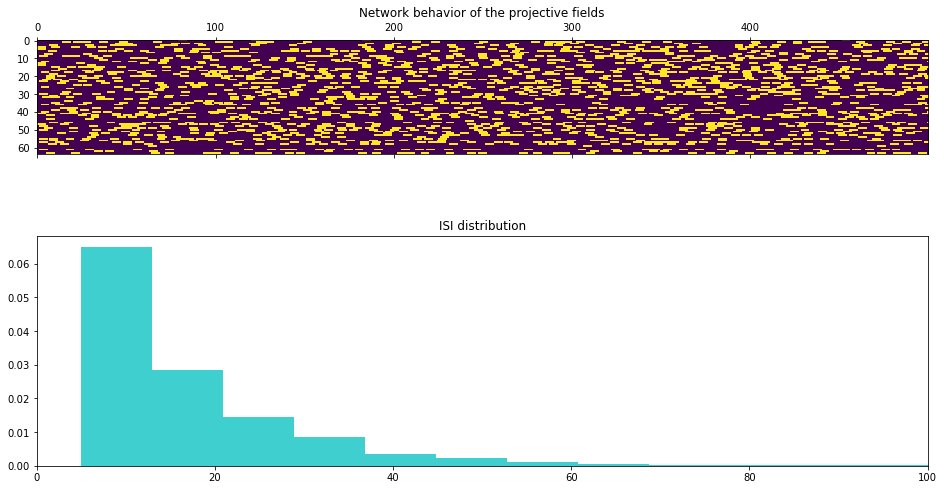

In [302]:
fig3 = plt.figure(constrained_layout=True, figsize = (13,7))
gs = fig3.add_gridspec(2, 2)
f3_ax1 = fig3.add_subplot(gs[0, :])
f3_ax1.set_title('Network behavior of the projective fields')
f3_ax1.matshow(response)
f3_ax2 = fig3.add_subplot(gs[1, :])
f3_ax2.set_title('ISI distribution')
f3_ax2.set_xlim(0,100)
f3_ax2.hist(ISI, 30, density=True, facecolor='c', alpha=0.75);


In [299]:
print("Associated CV value for this ISI distribution is: %.2f" %cv_ISI)

Associated CV value for this ISI distribution is: 0.96


## Spike timing dependent plasticity 

As a way of learning, neurons weaken or strengthen the connection between them to facilitate a cognitive function. We know that neurons work as a network, and firing is wiring in that scheme. Than a contingent firing patter inside the network should be showing us a pathway. Then, the pathway facilitating a cognitive function can be understood as a flow of information, and the most efficient way would be the one with min redundancy. The previous studies showed that, neurons tend to reduce that redundancy by arranging their wiring strength according to the contingency of the relation between them.

During the application of STDP, we noticed that the large value of tau - s_j results in collective spiking, instead of blocking it. We scale this time parameter using the results of the previous observations. According to the data (Zhang et al. 1998) and models (e.g, Song et al. 2000), Jesper Sjöström and Wulfram Gerstner report that this time constant tau_STDP should be on the order of 10 ms for both forward, and backward.

In [197]:
tau_STDP = 10
def post_synaptic_potential_weight(Image, weight, i, z):    
    weight[i, i] = 0                                                    # w_ii = 0
    time_course = np.matmul(np.transpose(weight[i]),z)                  # how other neurons contribute PSP now
    bias = np.matmul(np.transpose(Pf[:,i]),Image.reshape(64,1))        # regulation of own excitability
    return bias - time_course

In [198]:
def Gibbs_sampling_plasticity(Image, n_sampling):
    response_matrix = np.zeros([64,n_sampling])  # Initiate sampling matrix
    response_matrix[:,0] = z_initial             # Set z_initial as the first column
    
    ζ = np.zeros([64,n_sampling])                # accompanying matrix showing the refractory period
    ζ[:,0] = z_initial*tau                       # firing neurons get into refractory period
    
    weight = np.matmul(np.transpose(Pf[:,:]),Pf[:,:]) # produce the weight again here, and track its evolution
    
    spike_timing = np.zeros([64,n_sampling])     # record spike times
    
    for i in range(1, n_sampling):               # Start from the second column, and iterate through time
        response_matrix[:,i] = response_matrix[:,i-1]

        for j in range(64):                       
            if ζ[j, i-1] <= 1:                   # Make a draw if refractory period is end
                
                response_matrix[j, i] = 0
                transfer_ij = expit((post_synaptic_potential_weight(Image, weight, j, response_matrix[:,i])\
                                    - np.log(tau))) # expit for sigmoid fct
                response_matrix[j,i] = np.random.binomial(1, transfer_ij)
                
                if response_matrix[j,i] == 1:   # update refractory period
                    
                    nonzero = np.nonzero(ζ[:, i])
                    nonzero = np.asarray(nonzero[0])
                    for k in nonzero:
                        remaining_time_ref = ζ[k, i]
                        weight[k, j] = weight[k, j] - np.exp((tau - remaining_time_ref)/tau_STDP)
                        # decrease the wiring strength of the current neuron, going to the firing neuron
                        weight[j, k] = weight[j, k] + np.exp((tau - remaining_time_ref)/tau_STDP) 
                        # increase the wiring strength with the firing neuron
                    
                    ζ[j, i] = tau                
                    spike_timing[j, i] = i      # record spike time
                    
                else:
                    ζ[j, i] = 0
                
            else:
                ζ[j, i] = ζ[j, i-1] - 1
   
    return weight, response_matrix

**Now we will use this setting to observe how the inference change according using STDP, starting with a long sampling time on the same image.**

In [199]:
www, res = Gibbs_sampling_weight(images[333], 100)

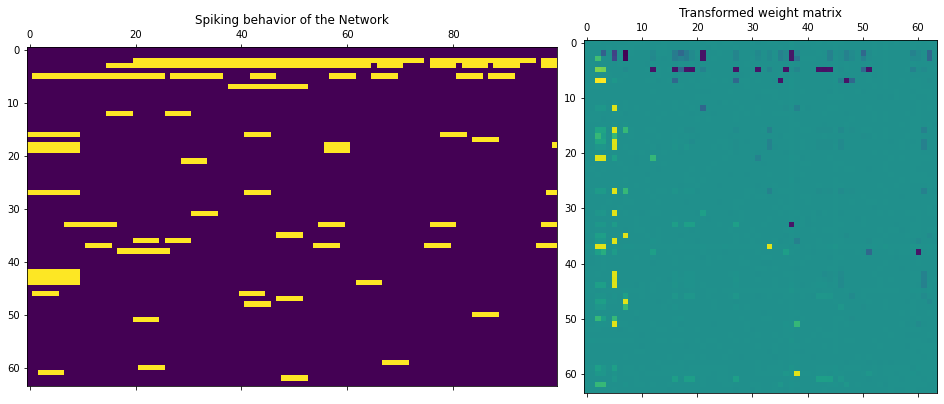

In [205]:
fig3 = plt.figure(constrained_layout=True, figsize = (13,7))
gs = fig3.add_gridspec(5, 11)
f3_ax1 = fig3.add_subplot(gs[:, 0:6])
f3_ax1.set_title('Spiking behavior of the Network')
f3_ax1.matshow(res)
f3_ax2 = fig3.add_subplot(gs[:, 7:])
f3_ax2.set_title('Transformed weight matrix')
f3_ax2.matshow(www)

In [214]:
www, res = Gibbs_sampling_weight(images[543], 1000)

In [305]:
posterior_543 = np.array([np.sum(res[i])/1000 for i in range(64)])
inferred_543 = np.matmul(Pf,posterior_543).reshape(8,8)

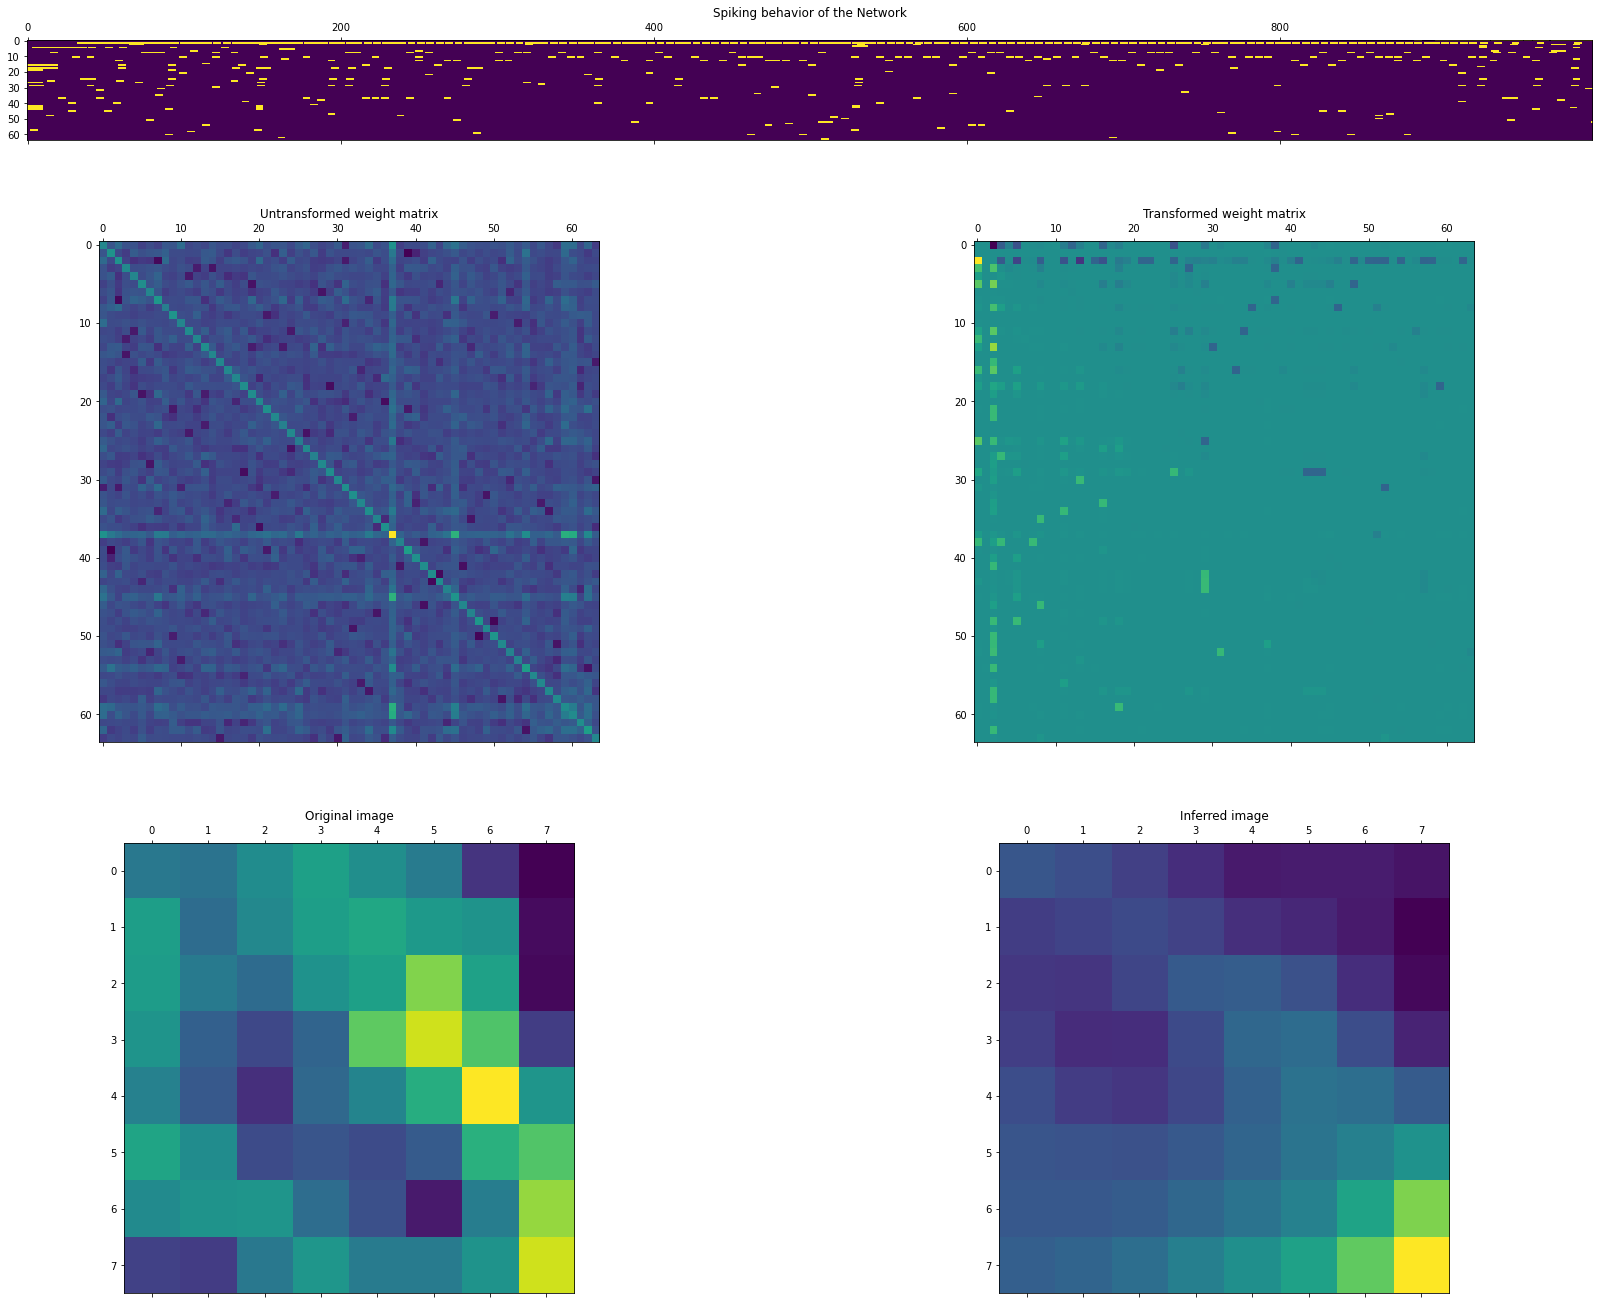

In [308]:
fig3 = plt.figure(constrained_layout=True, figsize = (23,18))
gs = fig3.add_gridspec(23, 18)
f3_ax1 = fig3.add_subplot(gs[0:2, :])
f3_ax1.set_title('Spiking behavior of the Network')
f3_ax1.matshow(res)
f3_ax2 = fig3.add_subplot(gs[3:13, 0:8])
f3_ax2.set_title('Untransformed weight matrix')
f3_ax2.matshow(W)
f3_ax3 = fig3.add_subplot(gs[3:13:, 9:])
f3_ax3.set_title('Transformed weight matrix')
f3_ax3.matshow(www)
f3_ax4 = fig3.add_subplot(gs[14:23, 0:8])
f3_ax4.set_title('Original image')
f3_ax4.matshow(images[543])
f3_ax5 = fig3.add_subplot(gs[14:23:, 9:])
f3_ax5.set_title('Inferred image')
f3_ax5.matshow(inferred_543)

**We can clearly see that STDP helped us to remove some noise like features in the inferred image, and also improved the stady firing characteristics. But, still it is not enough to say that we achieved an optimal inference scheme as it can be seen from the last row of the plots.**

In [325]:
def Gibbs_sampling_plasticity(Images, n_sampling):
    response_matrix = np.zeros([64,n_sampling])  # Initiate sampling matrix
    response_matrix[:,0] = z_initial             # Set z_initial as the first column
    
    ζ = np.zeros([64,n_sampling])                # accompanying matrix showing the refractory period
    ζ[:,0] = z_initial*tau                       # firing neurons get into refractory period
    
    weight = np.matmul(np.transpose(Pf[:,:]),Pf[:,:]) # produce the weight again here, and track its evolution
    
    spike_timing = np.zeros([64,n_sampling])     # record spike times
    
    
    len_images = np.shape(Images)[1]             # how many columns does images matrix have
    
    for l in range(len_images):
        
        Image = np.transpose(Images)[:, l]
        
        for i in range(1, n_sampling):               # Start from the second column, and iterate through time
            response_matrix[:,i] = response_matrix[:,i-1]

            for j in range(64):                       
                if ζ[j, i-1] <= 1:                   # Make a draw if refractory period is end
                
                    response_matrix[j, i] = 0
                    transfer_ij = expit((post_synaptic_potential_weight(Image, weight, j, response_matrix[:,i])\
                                    - np.log(tau))) # expit for sigmoid fct
                    response_matrix[j,i] = np.random.binomial(1, transfer_ij)
                
                    if response_matrix[j,i] == 1:   # update refractory period
                    
                        nonzero = np.nonzero(ζ[:, i])
                        nonzero = np.asarray(nonzero[0])
                        for k in nonzero:
                            remaining_time_ref = ζ[k, i]
                            weight[k, j] = weight[k, j] - np.exp((tau - remaining_time_ref)/tau_STDP)
                            # decrease the wiring strength of the current neuron, going to the firing neuron
                            weight[j, k] = weight[j, k] + np.exp((tau - remaining_time_ref)/tau_STDP) 
                            # increase the wiring strength with the firing neuron
                    
                        ζ[j, i] = tau                
                        spike_timing[j, i] = i      # record spike time
                    
                    else:
                        ζ[j, i] = 0
                
                else:
                    ζ[j, i] = ζ[j, i-1] - 1
   
    return weight, response_matrix

**We prepared our functions. Now, we can test them with series of natural images, with short period of sampling.**

In [326]:
numberOFsampling = 10                                                     # Number of sampling 
numberOFimages = 100                                                       # Number of random natural images
rand_order = np.random.choice(10000, numberOFimages, replace=False)       # Draw order of the images randomly
rand_images = np.zeros([numberOFimages,64])                               # Create empty array
i = 0
while i < numberOFimages:                                                  # Chose random images from the collection
    rand_images[i] = images[rand_order[i]].reshape(64)                   # with the order drawn above
    i += 1

In [327]:
weight_comb, res_comb = Gibbs_sampling_plasticity(rand_images, numberOFsampling)

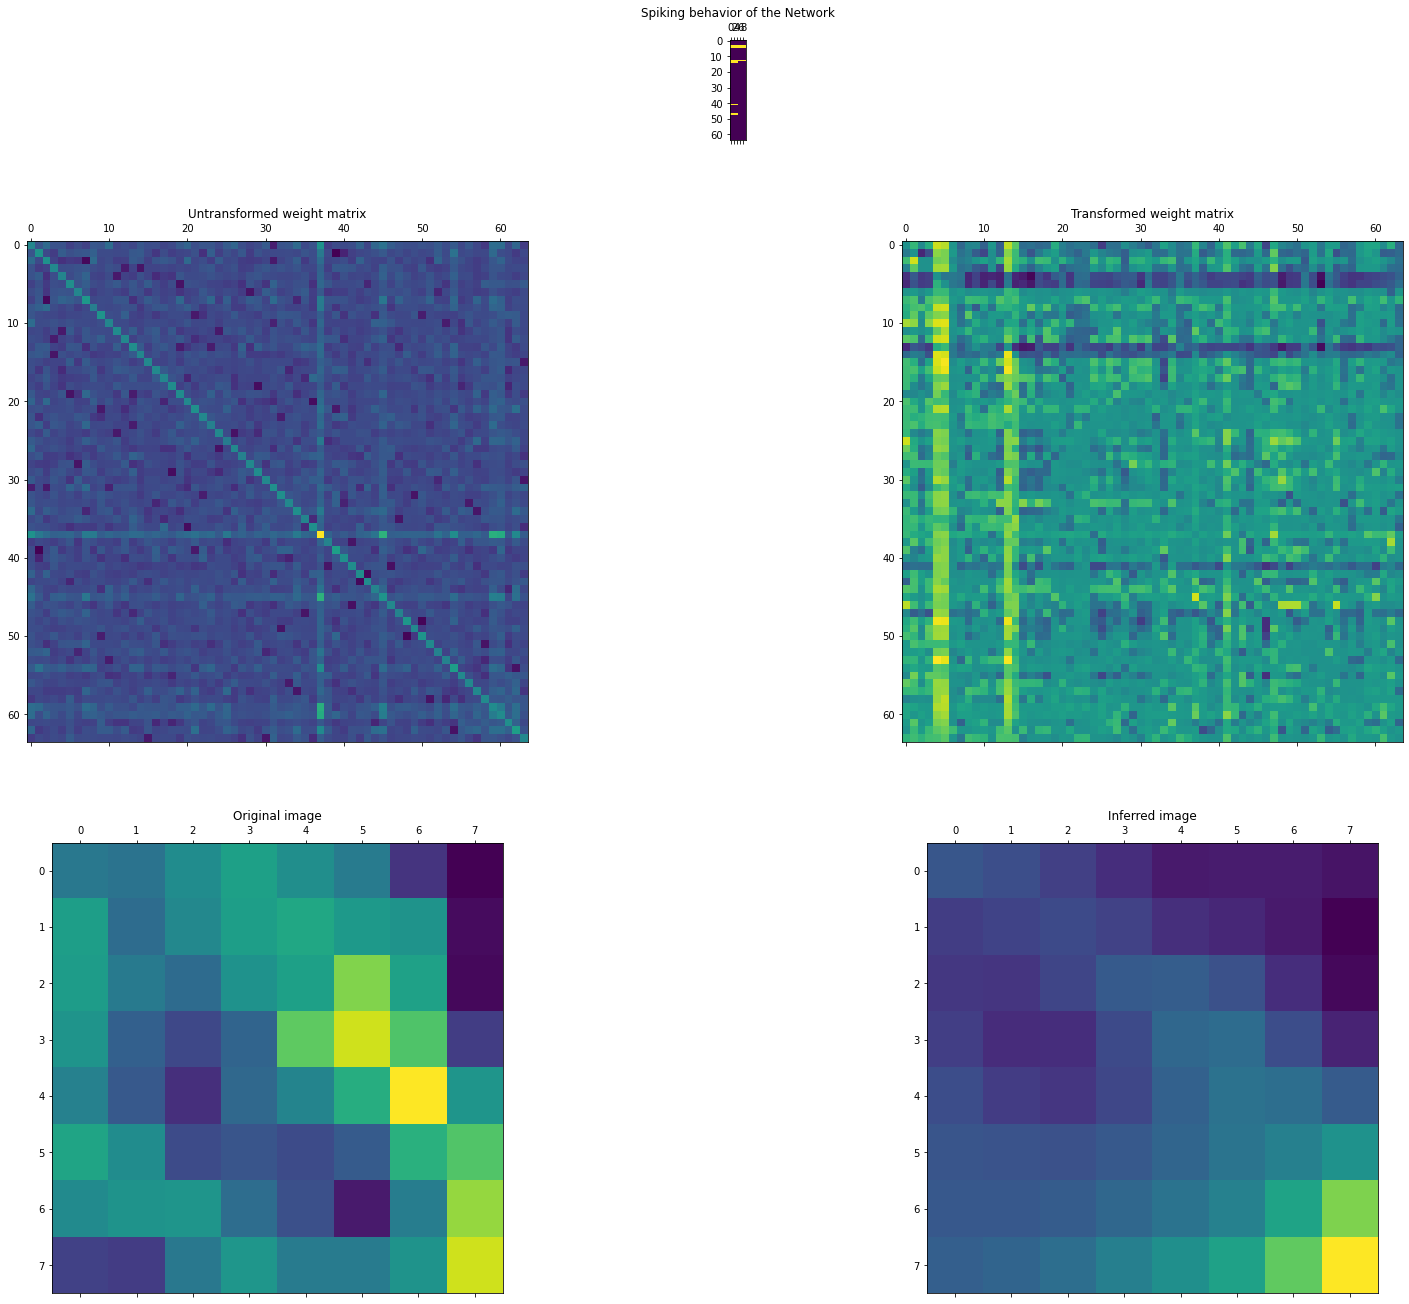

In [321]:
fig3 = plt.figure(constrained_layout=True, figsize = (23,18))
gs = fig3.add_gridspec(23, 18)
f3_ax1 = fig3.add_subplot(gs[0:2, :])
f3_ax1.set_title('Spiking behavior of the Network')
f3_ax1.matshow(res_comb)
f3_ax2 = fig3.add_subplot(gs[3:13, 0:8])
f3_ax2.set_title('Untransformed weight matrix')
f3_ax2.matshow(W)
f3_ax3 = fig3.add_subplot(gs[3:13:, 9:])
f3_ax3.set_title('Transformed weight matrix')
f3_ax3.matshow(weight_comb)
f3_ax4 = fig3.add_subplot(gs[14:23, 0:8])
f3_ax4.set_title('Original image')
f3_ax4.matshow(images[543])
f3_ax5 = fig3.add_subplot(gs[14:23:, 9:])
f3_ax5.set_title('Inferred image')
f3_ax5.matshow(inferred_543)